# House Pricing - Advanced Regression - Assignment

# Step 1: Loading and understanding the data

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load the data into variable
housing_data = pd.read_csv("train.csv")
housing_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Checking number of Rows and Columns
housing_data.shape

(1460, 81)

In [4]:
#Checking for data types and missing values
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Step 2: Visualization, Cleaning and mapping of data

In [5]:
#Fetch the column details having 80% missing values
pct_null = housing_data.isnull().sum() / len(housing_data)
missing_features = pct_null[pct_null > 0.80].keys()
missing_features

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [6]:
#Drop the columns having 80% missing values
housing_data.drop(missing_features,axis=1,inplace=True)
housing_data.shape

(1460, 77)

In [7]:
#Drop the column Id since its not contributing to model building
housing_data.drop(['Id'],axis=1,inplace=True)
housing_data.shape

(1460, 76)

### Checking for columns having majority of single values for the dataset and percentage of single value in each column

In [8]:
housing_data.nunique().sort_values().head(15)

CentralAir      2
Street          2
Utilities       2
HalfBath        3
PavedDrive      3
BsmtHalfBath    3
LandSlope       3
GarageFinish    3
Fireplaces      4
LotShape        4
BsmtExposure    4
BsmtFullBath    4
KitchenAbvGr    4
BsmtCond        4
KitchenQual     4
dtype: int64

In [9]:
housing_data.Street.value_counts(normalize=True)*100

Pave    99.589041
Grvl     0.410959
Name: Street, dtype: float64

In [10]:
housing_data.Utilities.value_counts(normalize=True)*100

AllPub    99.931507
NoSeWa     0.068493
Name: Utilities, dtype: float64

In [11]:
housing_data.CentralAir.value_counts(normalize=True)*100

Y    93.493151
N     6.506849
Name: CentralAir, dtype: float64

### Dropping columns having more than 93% of single values


In [12]:
housing_data.drop(['Street','Utilities','CentralAir'],axis = 1, inplace = True)
housing_data.shape

(1460, 73)

### Fill NA values for columns having more than 5% missing values

In [13]:
#Checking for further missing values per column
null_value_series = housing_data.isnull().sum()/len(housing_data.index)*100

#Listing columns having more than 5% missing values
null_value_series = null_value_series[null_value_series > 5]
null_value_series

LotFrontage     17.739726
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
dtype: float64

In [14]:
#For numeric columns fill the missing values with median
housing_data.GarageYrBlt = housing_data.GarageYrBlt.fillna(housing_data.GarageYrBlt.median())
housing_data.LotFrontage = housing_data.LotFrontage.fillna(housing_data.LotFrontage.median())

In [15]:
#For Categorical columns fill the missing values with none
cate_missing_columns = ["MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]
for categorical in cate_missing_columns:
    housing_data[categorical].fillna('none',inplace=True)

### Drop the NA rows from columns having less than 5% missing values

In [16]:
#Dropping rows where there are NaN values as we have sufficient data for analysis
housing_data = housing_data.dropna(axis='rows')
housing_data.shape

(1451, 73)

### Deriving a column for the age of property as PropertyAge

In [17]:
housing_data['PropertyAge'] = (housing_data['YrSold'] - housing_data['YearBuilt'])
housing_data['PropertyAge'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1451 entries, 0 to 1459
Series name: PropertyAge
Non-Null Count  Dtype
--------------  -----
1451 non-null   int64
dtypes: int64(1)
memory usage: 22.7 KB


In [18]:
# Dropping Month sold, year sold, year built, year remodelled since we derived Property Age column
housing_data = housing_data.drop(['MoSold'], axis = 1)
housing_data = housing_data.drop(['YrSold'], axis = 1)
housing_data = housing_data.drop(['YearBuilt'], axis = 1)
housing_data = housing_data.drop(['YearRemodAdd'], axis = 1)
housing_data.head() 

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition,SalePrice,PropertyAge
0,60,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,61,0,0,0,0,0,WD,Normal,208500,5
1,20,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,0,0,0,0,0,0,WD,Normal,181500,31
2,60,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,42,0,0,0,0,0,WD,Normal,223500,7
3,70,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,35,272,0,0,0,0,WD,Abnorml,140000,91
4,60,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,84,0,0,0,0,0,WD,Normal,250000,8


## Observation : At the end of data cleaning we have 1338 rows and 70 columns

<AxesSubplot:>

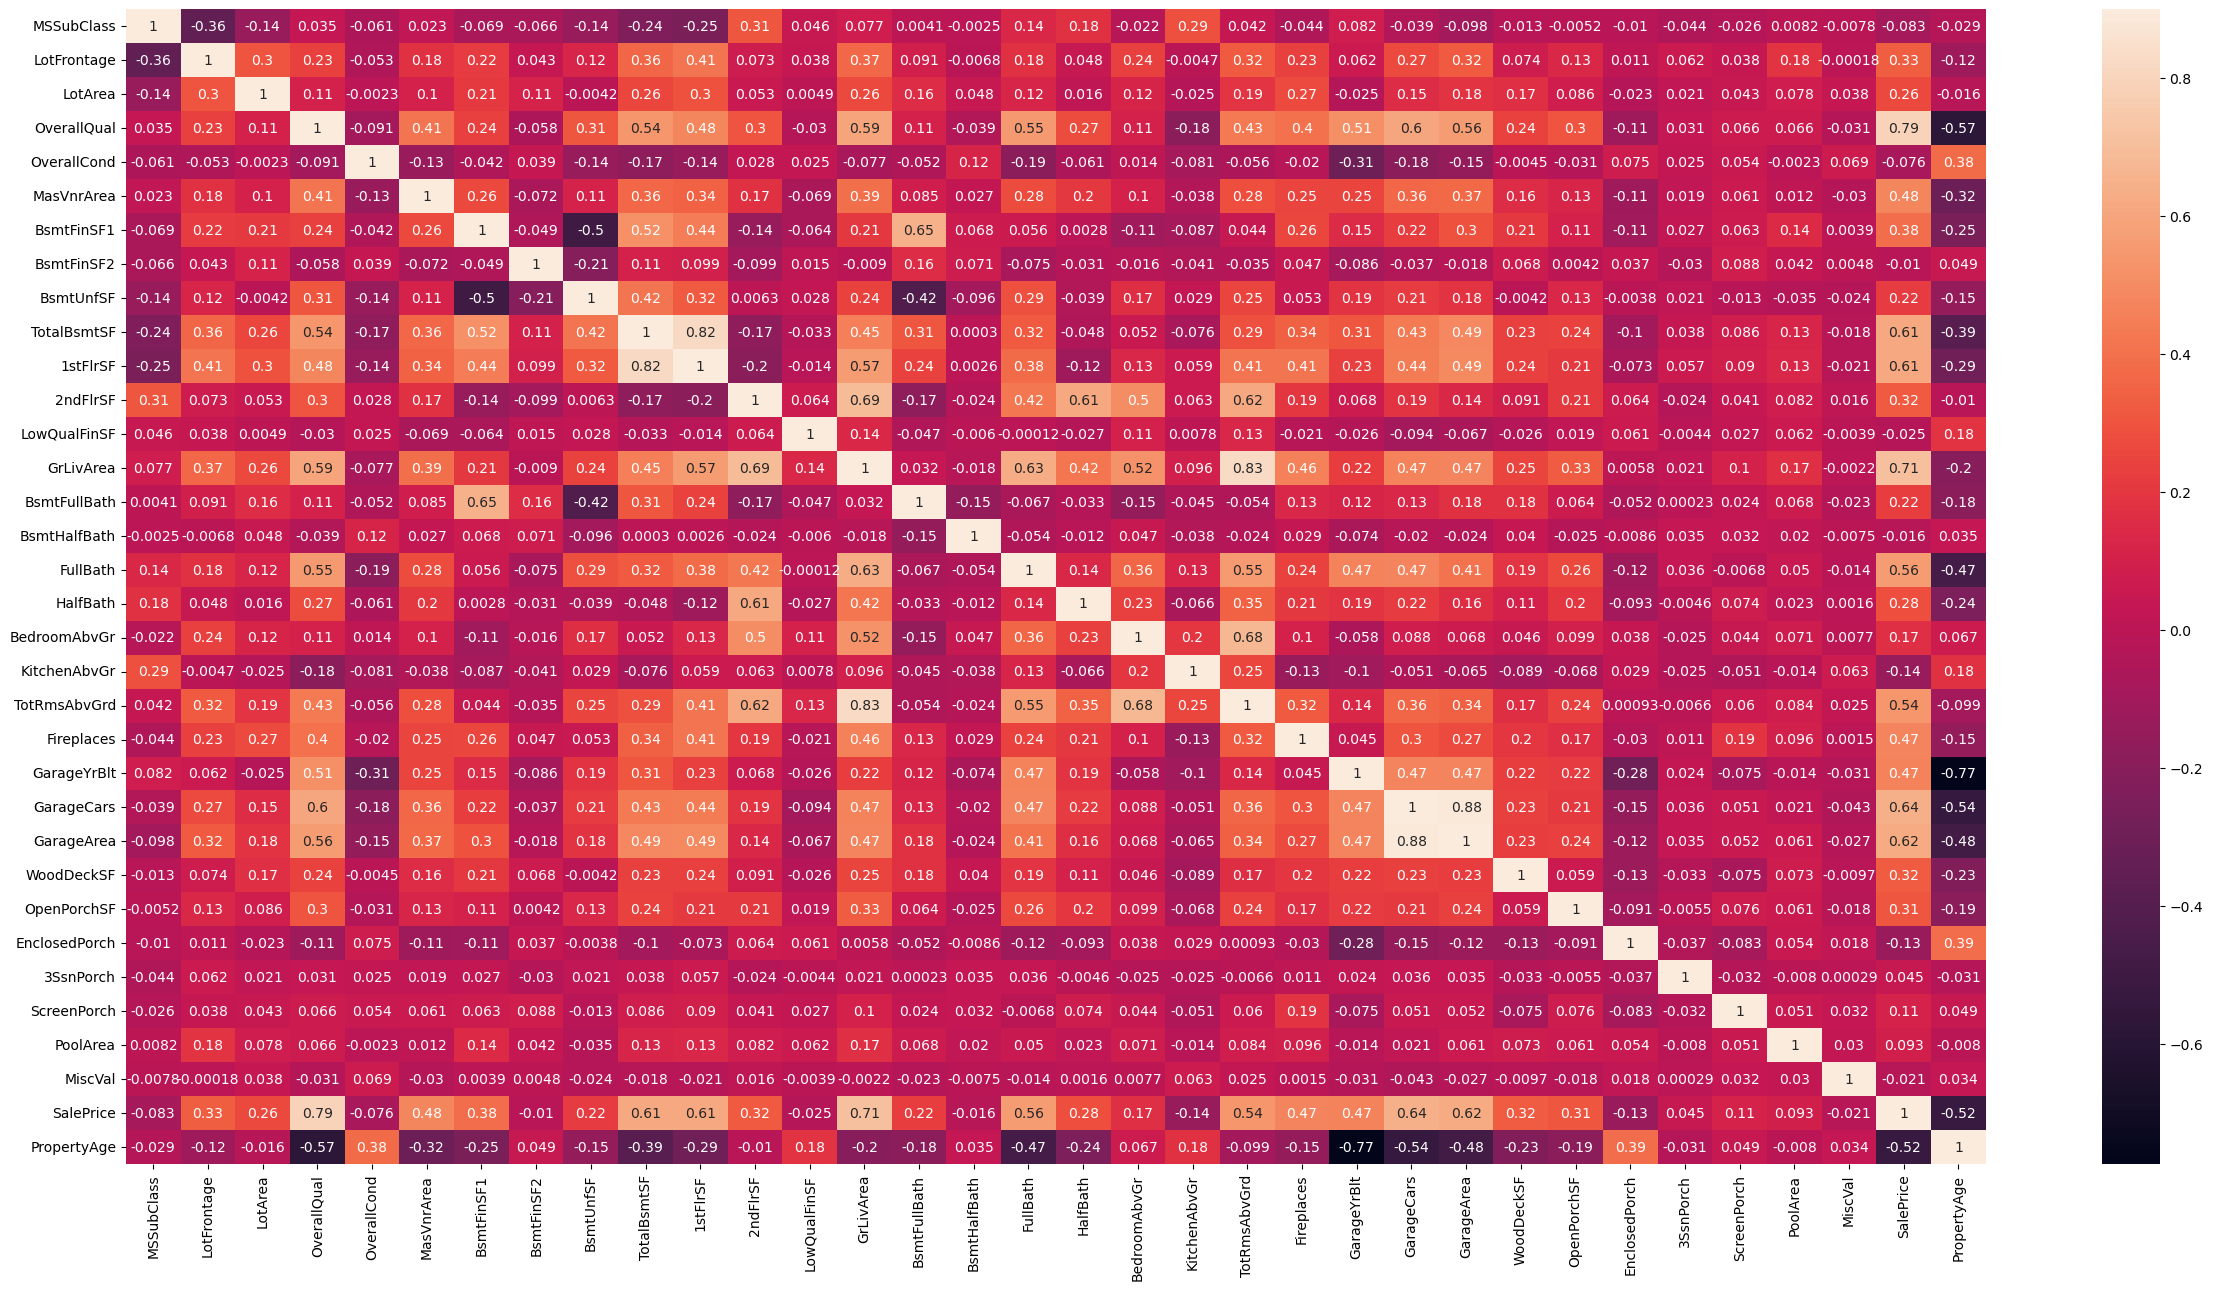

In [19]:
#Plot the heatmap to check co-relation between features
corrmat = housing_data.corr()
plt.subplots(figsize=(30,15))
sns.heatmap(corrmat, vmax=0.9, annot=True)

In [20]:
#Get the feature list which are having high co-relation with Targer variable SalePrice
corrmat_series = corrmat.loc['SalePrice']
corrmat_series = corrmat_series[corrmat_series > 0.5]
corrmat_series

OverallQual     0.790085
TotalBsmtSF     0.613299
1stFlrSF        0.606969
GrLivArea       0.710073
FullBath        0.562710
TotRmsAbvGrd    0.536366
GarageCars      0.639749
GarageArea      0.622484
SalePrice       1.000000
Name: SalePrice, dtype: float64

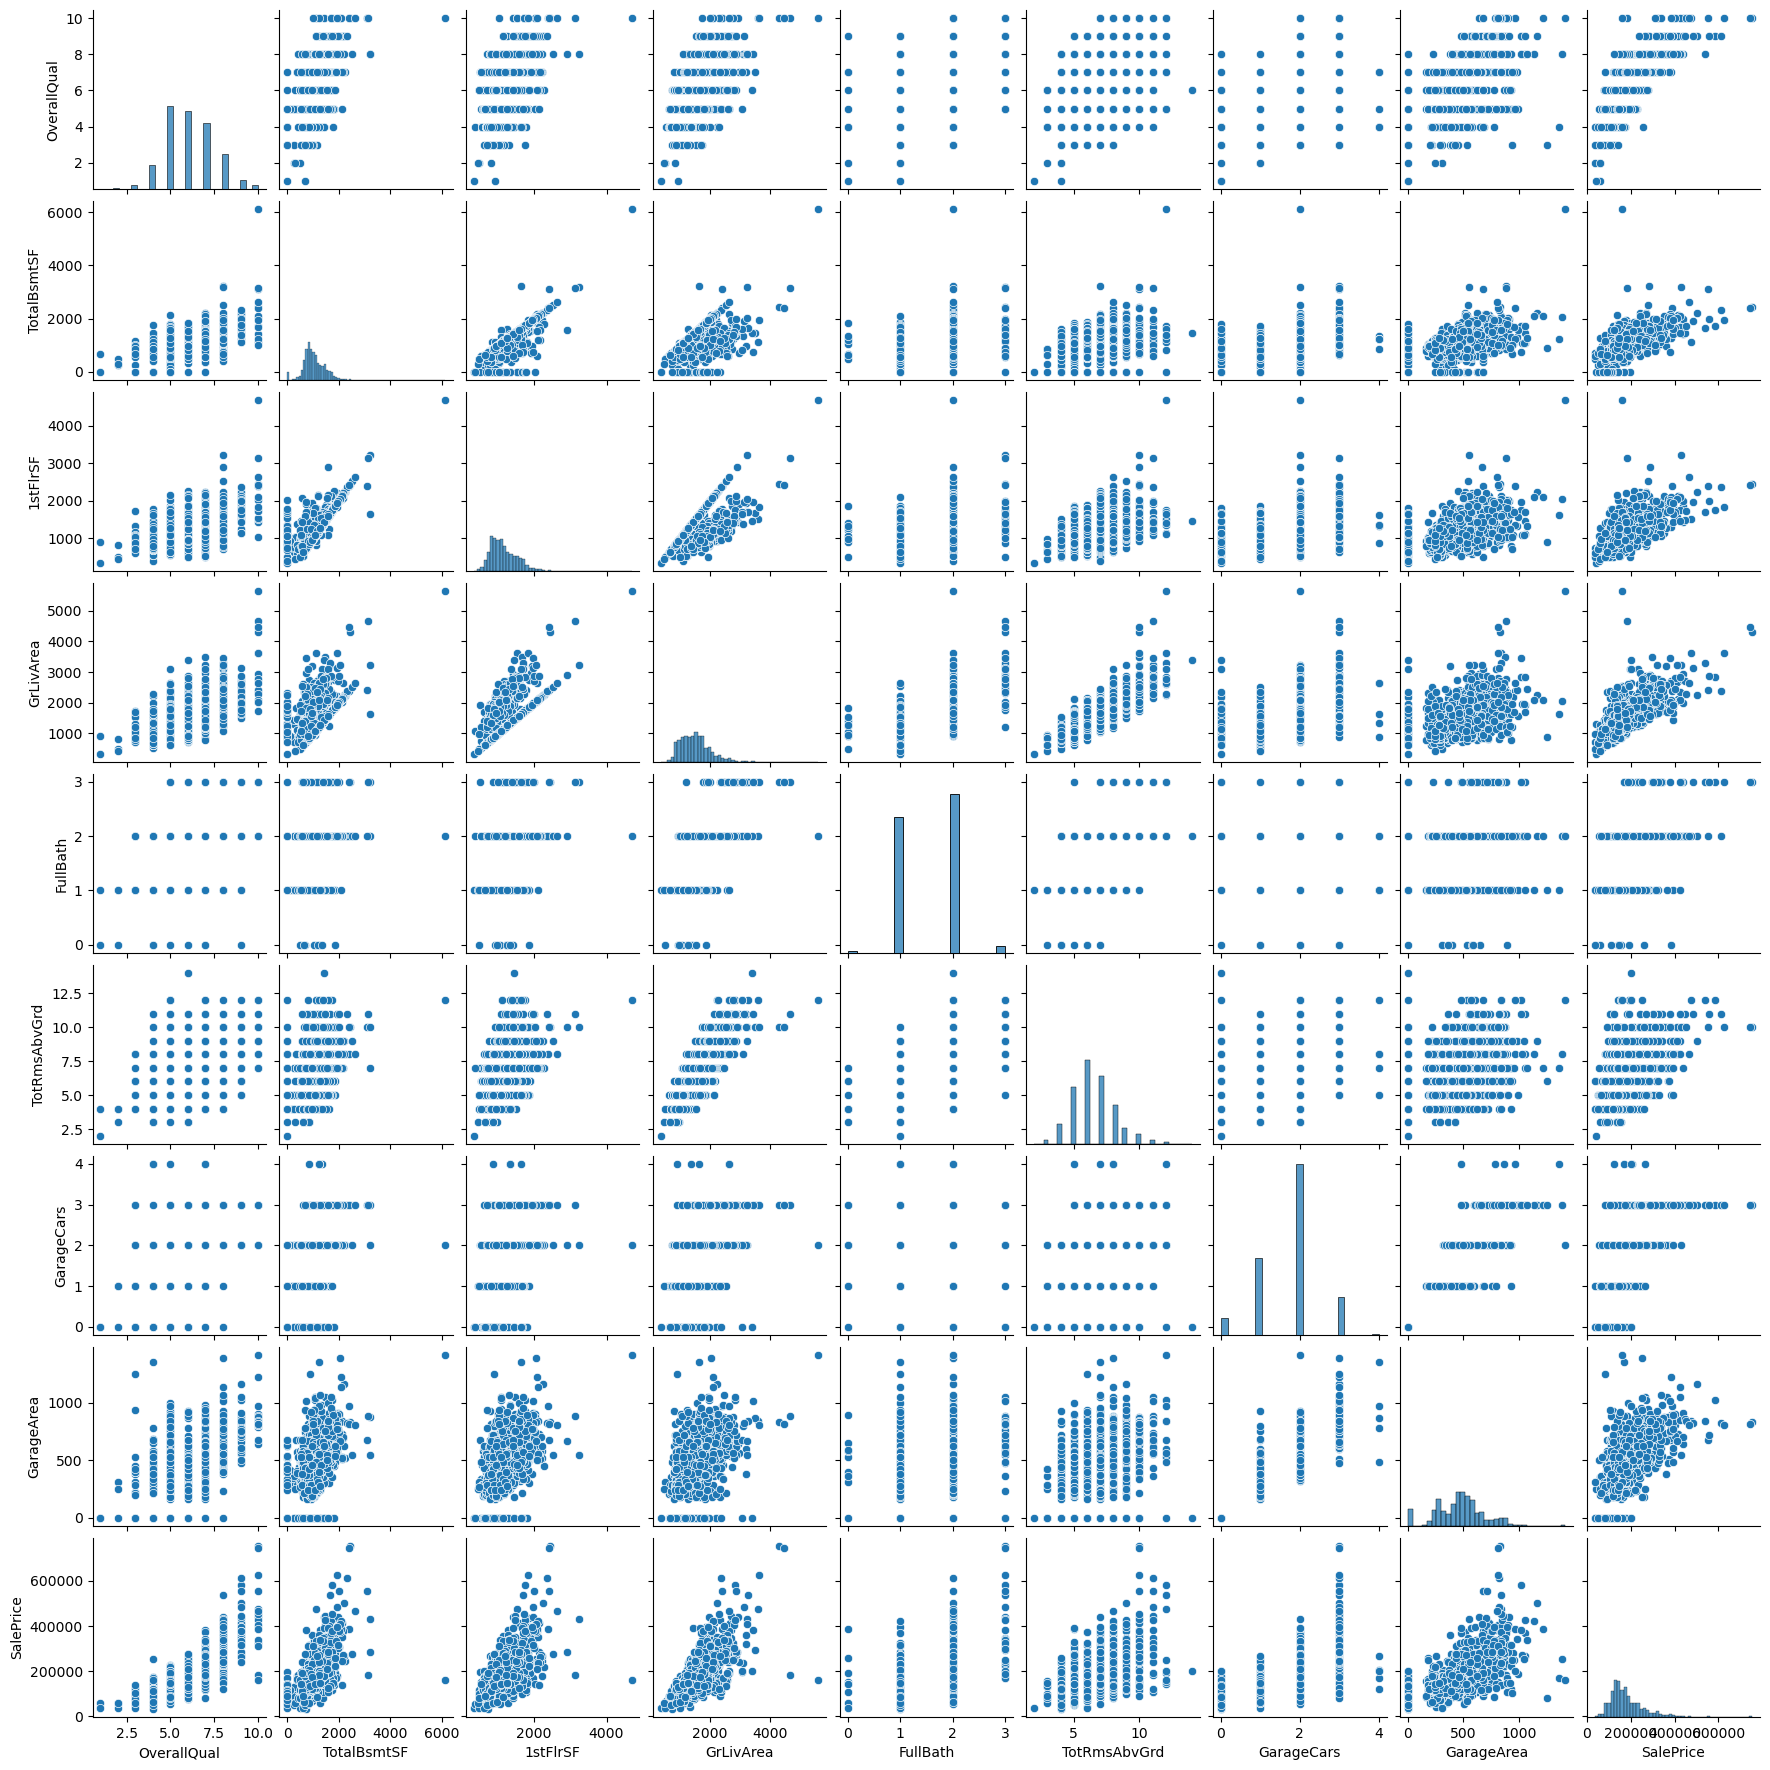

In [21]:
#Let us use pair plots to understand relationship of these variables with SalePrice
sns.pairplot(housing_data[corrmat_series.index.to_list()],height=2)
plt.show()

## Observation: Some features have linear relationship with target variable

### Check for relationship between categorical variables with SalePrice

In [22]:
#Numeric features
numeric_col = list(housing_data.dtypes[housing_data.dtypes != 'object'].index)
print(numeric_col)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'PropertyAge']


In [23]:
#Categorical features
categorical_col = list(housing_data.dtypes[housing_data.dtypes == 'object'].index)
print(categorical_col)

['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


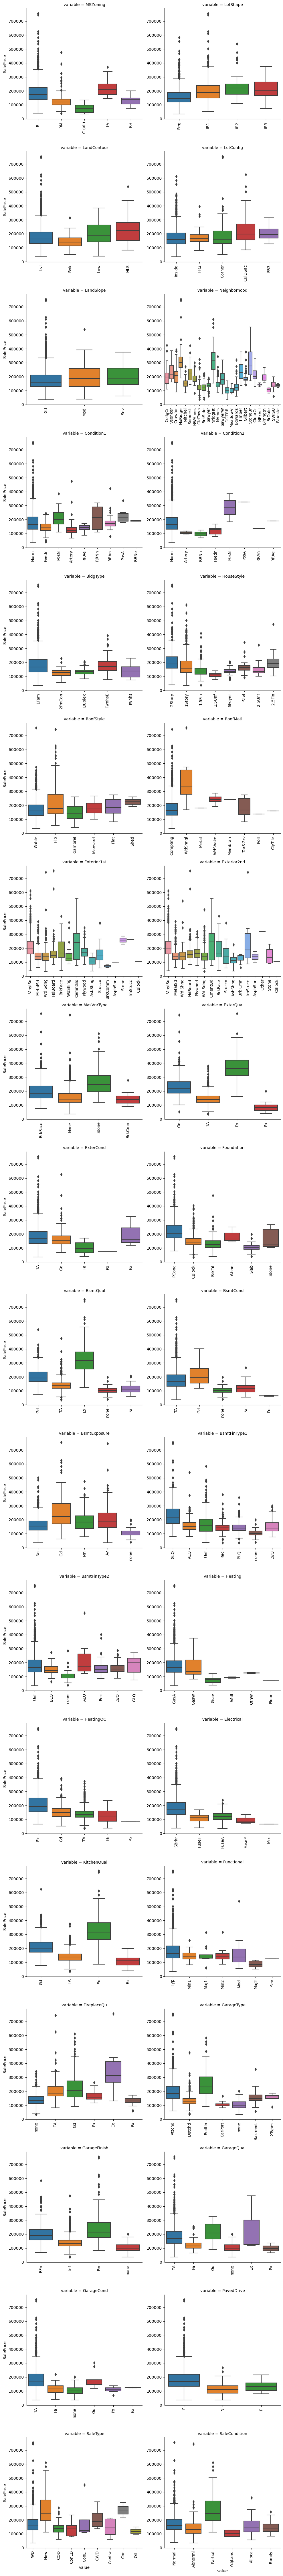

In [24]:
#Plotting box plot for Categorical features vs SalePrice
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(housing_data, id_vars=['SalePrice'], value_vars=categorical_col)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "SalePrice")

## Observation : Categorical features has varied relationship with SalePrice

# Step 3 : Data Preparation

### Dummy variable creation for categorical variables

In [25]:
house_eda_data = housing_data

In [26]:
#Dummy variable creation
housing_dummy = pd.get_dummies(house_eda_data[categorical_col],drop_first=True)
housing_dummy.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


In [27]:
#Dropping duplicate Categorical columns
house_eda_data = house_eda_data.drop(categorical_col,axis=1)
house_eda_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,PropertyAge
0,60,65.0,8450,7,5,196.0,706,0,150,856,...,548,0,61,0,0,0,0,0,208500,5
1,20,80.0,9600,6,8,0.0,978,0,284,1262,...,460,298,0,0,0,0,0,0,181500,31
2,60,68.0,11250,7,5,162.0,486,0,434,920,...,608,0,42,0,0,0,0,0,223500,7
3,70,60.0,9550,7,5,0.0,216,0,540,756,...,642,0,35,272,0,0,0,0,140000,91
4,60,84.0,14260,8,5,350.0,655,0,490,1145,...,836,192,84,0,0,0,0,0,250000,8


In [28]:
#Combining dummy variable dataset with original data
house_eda_data = pd.concat([house_eda_data, housing_dummy], axis=1)
house_eda_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,196.0,706,0,150,856,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,0.0,978,0,284,1262,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,162.0,486,0,434,920,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,0.0,216,0,540,756,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,350.0,655,0,490,1145,...,0,0,0,0,1,0,0,0,1,0


### Test and Train split

In [29]:
housing_train,housing_test = train_test_split(house_eda_data,train_size=0.7,random_state=100)
print(housing_train.shape)
print(housing_test.shape)

(1015, 241)
(436, 241)


In [30]:
#Apply MinMax for numeric values on Train and Test set
scaler = MinMaxScaler()
housing_train[numeric_col] = scaler.fit_transform(housing_train[numeric_col])
housing_test[numeric_col] = scaler.transform(housing_test[numeric_col])

In [31]:
housing_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
801,0.058824,0.065068,0.016359,0.250,0.714286,0.000000,0.034904,0.000000,0.427654,0.195745,...,0,0,0,0,1,0,0,0,1,0
569,0.411765,0.164384,0.026792,0.375,0.428571,0.000000,0.167080,0.000000,0.000000,0.154337,...,0,0,0,0,1,0,0,0,1,0
1181,0.588235,0.147260,0.020038,0.750,0.428571,0.116250,0.262225,0.000000,0.051370,0.261866,...,0,0,1,0,0,0,0,0,0,1
808,0.352941,0.219178,0.056557,0.375,0.428571,0.654375,0.091425,0.114286,0.162671,0.167594,...,0,0,0,0,1,0,0,0,1,0
1095,0.000000,0.195205,0.037472,0.500,0.428571,0.000000,0.004252,0.000000,0.552226,0.215057,...,0,0,0,0,1,0,0,0,1,0


In [32]:
housing_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
357,0.588235,0.078767,0.013667,0.375,0.428571,0.0,0.154855,0.000000,0.114726,0.186907,...,0,0,0,0,1,0,0,0,1,0
824,0.000000,0.205479,0.046348,0.750,0.428571,0.0,0.000000,0.000000,0.637414,0.243699,...,0,0,1,0,0,0,0,0,0,1
369,0.000000,0.164384,0.039870,0.375,0.714286,0.0,0.012757,0.230357,0.313784,0.173977,...,0,0,0,0,1,0,0,0,1,0
291,1.000000,0.116438,0.020505,0.375,0.571429,0.0,0.037208,0.000000,0.244007,0.127660,...,0,0,0,0,1,0,0,0,1,0
134,0.000000,0.195205,0.042230,0.375,0.571429,0.0,0.100992,0.000000,0.381421,0.239116,...,0,0,0,0,1,0,0,0,1,0


In [33]:
#Derive X and y variables
y_train = housing_train.pop('SalePrice')
X_train = housing_train
print(X_train.shape)
print(y_train.shape)

(1015, 240)
(1015,)


In [34]:
y_test = housing_test.pop('SalePrice')
X_test = housing_test
print(X_test.shape)
print(y_test.shape)

(436, 240)
(436,)


# Step 4 : Model building and evaluation


In [35]:
#Build Linear Regression model and check the accuracy
lm = LinearRegression()
lm.fit(X_train,y_train)
#Use RFE to choose top 100 features
rfe = RFE(lm,n_features_to_select=100)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=100)

In [36]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 65),
 ('LotFrontage', True, 1),
 ('LotArea', True, 1),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('MasVnrArea', True, 1),
 ('BsmtFinSF1', True, 1),
 ('BsmtFinSF2', True, 1),
 ('BsmtUnfSF', True, 1),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 73),
 ('BsmtHalfBath', False, 36),
 ('FullBath', False, 111),
 ('HalfBath', False, 112),
 ('BedroomAbvGr', True, 1),
 ('KitchenAbvGr', True, 1),
 ('TotRmsAbvGrd', False, 66),
 ('Fireplaces', True, 1),
 ('GarageYrBlt', True, 1),
 ('GarageCars', True, 1),
 ('GarageArea', False, 61),
 ('WoodDeckSF', False, 48),
 ('OpenPorchSF', False, 134),
 ('EnclosedPorch', False, 110),
 ('3SsnPorch', False, 44),
 ('ScreenPorch', False, 131),
 ('PoolArea', True, 1),
 ('MiscVal', False, 114),
 ('PropertyAge', True, 1),
 ('MSZoning_FV', True, 1),
 ('MSZoning_RH', True, 1),
 ('MSZoning_RL', True, 1),
 ('MSZoning_RM', True, 1)

In [37]:
#Will consider only the columns that are returned as True from RFE
req_col = X_train.columns[rfe.support_]
X_train_rfe = X_train[req_col]
X_test_rfe = X_test[req_col]
X_train_rfe.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_none,GarageCond_none,SaleType_Con,SaleType_New,SaleType_Oth,SaleCondition_Partial
801,0.065068,0.016359,0.250,0.714286,0.000000,0.034904,0.000000,0.427654,0.195745,0.178185,...,0,0,0,1,0,0,0,0,0,0
569,0.164384,0.026792,0.375,0.428571,0.000000,0.167080,0.000000,0.000000,0.154337,0.118712,...,0,0,0,1,0,0,0,0,0,0
1181,0.147260,0.020038,0.750,0.428571,0.116250,0.262225,0.000000,0.051370,0.261866,0.285378,...,0,0,0,1,0,0,0,1,0,1
808,0.219178,0.056557,0.375,0.428571,0.654375,0.091425,0.114286,0.162671,0.167594,0.152327,...,0,0,0,1,0,0,0,0,0,0
1095,0.195205,0.037472,0.500,0.428571,0.000000,0.004252,0.000000,0.552226,0.215057,0.205924,...,0,0,0,1,0,0,0,0,0,0


In [38]:
#Building linear regression again with columns selected from RFE
lm.fit(X_train_rfe,y_train)

LinearRegression()

In [39]:
#r2 Score for training data prediction
y_train_pred = lm.predict(X_train_rfe)
r2_score(y_true=y_train,y_pred=y_train_pred)

0.9314631901127957

In [40]:
#r2 Score for training data prediction
y_test_pred = lm.predict(X_test_rfe)
r2_score(y_true=y_test,y_pred=y_test_pred)

-8.931378003719003e+19

## Observation : 
## Training r2 value is good, but testing r2 value is not good, model is overfitting on the training data, lets use regularization now¶

# Step 5 : Ridge & Lasso Regression

Let's now try predicting car prices, a dataset used in simple linear regression, to perform ridge and lasso regression

### Ridge Regression

In [41]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [42]:
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006728,0.000701,0.001925,0.000096,0.0001,{'alpha': 0.0001},-0.034375,-0.022652,-0.031100,-0.030368,...,-0.029665,0.003846,24,-0.016091,-0.017961,-0.017284,-0.017446,-0.016066,-0.016970,0.000761
1,0.006359,0.001230,0.001876,0.000312,0.0010,{'alpha': 0.001},-0.034365,-0.022589,-0.030984,-0.030241,...,-0.029592,0.003853,23,-0.016091,-0.017950,-0.017268,-0.017448,-0.016066,-0.016965,0.000757
2,0.005652,0.000610,0.001674,0.000046,0.0100,{'alpha': 0.01},-0.034272,-0.022419,-0.030067,-0.029380,...,-0.029155,0.003812,22,-0.016092,-0.018012,-0.017291,-0.017557,-0.016196,-0.017030,0.000760
3,0.005876,0.000563,0.001761,0.000132,0.0500,{'alpha': 0.05},-0.033941,-0.023904,-0.028375,-0.028824,...,-0.028988,0.003213,20,-0.016103,-0.019161,-0.018166,-0.018517,-0.017390,-0.017868,0.001051
4,0.006991,0.001259,0.002702,0.001573,0.1000,{'alpha': 0.1},-0.033614,-0.024829,-0.027816,-0.028824,...,-0.029028,0.002871,21,-0.016146,-0.020089,-0.018997,-0.019322,-0.018289,-0.018569,0.001343


In [43]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 6.0}


In [44]:
#Fitting Ridge model for alpha = 6 and printing coefficients which have been penalised

alpha =6

ridge = Ridge(alpha=alpha)
        
ridge.fit(X_train, y_train)

Ridge(alpha=6)

In [45]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train_ridge = ridge.predict(X_train)
y_pred_test_ridge = ridge.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train_ridge)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test_ridge)
print(r2_test_lr)
metric3.append(r2_test_lr)



0.887887847998989
0.8718539219835754


Text(0, 0.5, 'Sales Price')

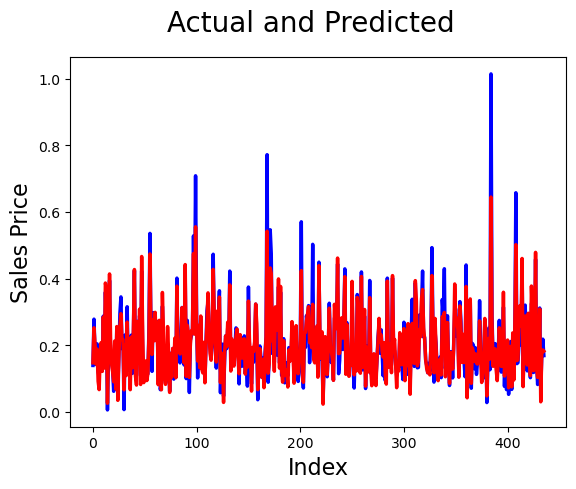

In [46]:
#Validate the Test Results with actuals

c = [i for i in range(0,y_test.shape[0],1)]
fig = plt.figure()
plt.plot(c, y_test, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c, y_pred_test_ridge, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              
plt.xlabel('Index', fontsize=16)                               
plt.ylabel('Sales Price', fontsize=16)

## Observation : After applying Ridge regression r2 score for train and test set is close to each other

In [47]:
#Derive Model Parameters
model_parameter = list(ridge.coef_)
model_parameter.insert(0,ridge.intercept_)
cols = X_train.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feature','Coef']

In [48]:
#Printing top 10 features co-efficients
ridge_coef.sort_values(by='Coef',ascending=False).head(10)

,Feature,Coef
4,OverallCond,0.085118
14,BsmtFullBath,0.065187
12,LowQualFinSF,0.062483
64,Neighborhood_NridgHt,0.054082
21,Fireplaces,0.053845
24,GarageArea,0.051881
11,2ndFlrSF,0.048273
71,Neighborhood_Timber,0.039226
65,Neighborhood_OldTown,0.038969
17,HalfBath,0.038561


### Lasso Regression

In [49]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [50]:
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.017915,0.001886,0.002072,0.000292,0.0001,{'alpha': 0.0001},-0.030721,-0.023795,-0.025181,-0.026141,...,-0.026400,0.002327,1,-0.018559,-0.023176,-0.022082,-0.022218,-0.021889,-0.021585,0.001577
1,0.005318,0.000126,0.001871,0.000521,0.0010,{'alpha': 0.001},-0.033313,-0.029076,-0.028156,-0.030109,...,-0.030944,0.002337,2,-0.027249,-0.030478,-0.029872,-0.030043,-0.029756,-0.029479,0.001142
2,0.003949,0.000091,0.001748,0.000405,0.0100,{'alpha': 0.01},-0.058772,-0.056650,-0.052549,-0.049903,...,-0.055062,0.003313,3,-0.053617,-0.054067,-0.055187,-0.055512,-0.054406,-0.054558,0.000701
3,0.003407,0.000257,0.001595,0.000039,0.0500,{'alpha': 0.05},-0.087787,-0.081173,-0.083138,-0.075176,...,-0.081710,0.004053,4,-0.079706,-0.081914,-0.080638,-0.083708,-0.082043,-0.081602,0.001360
4,0.003324,0.000090,0.002382,0.001125,0.1000,{'alpha': 0.1},-0.087787,-0.081173,-0.083138,-0.075176,...,-0.081710,0.004053,4,-0.079706,-0.081914,-0.080638,-0.083708,-0.082043,-0.081602,0.001360


In [51]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [52]:
#Fitting Lasso model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [53]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train_lasso = lasso.predict(X_train)
y_pred_test_lasso = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train_lasso)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test_lasso)
print(r2_test_lr)
metric3.append(r2_test_lr)

0.899906666308757
0.8675648935049525


Text(0, 0.5, 'Sales Price')

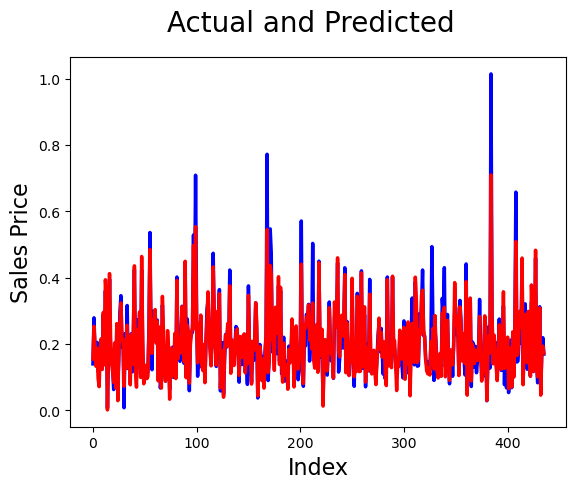

In [54]:
#Validate the Test Results with actuals

c = [i for i in range(0,y_test.shape[0],1)]
fig = plt.figure()
plt.plot(c, y_test, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c, y_pred_test_lasso, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              
plt.xlabel('Index', fontsize=16)                               
plt.ylabel('Sales Price', fontsize=16)

## Observation : After applying Lasso regression r2 score for train and test set is close to each other

In [55]:
#Derive Model co-efficient
model_param = list(lasso.coef_)
model_param.insert(0,lasso.intercept_)
cols = X_train.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Feature','Coef']

In [56]:
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Feature,Coef
14,BsmtFullBath,0.305401
4,OverallCond,0.122097
3,OverallQual,0.067269
24,GarageArea,0.066595
111,Exterior1st_AsphShn,0.066161
64,Neighborhood_NridgHt,0.057165
5,MasVnrArea,0.046829
65,Neighborhood_OldTown,0.045830
71,Neighborhood_Timber,0.042826
15,BsmtHalfBath,0.034480


## Conclusion : 
### 1. After using Ridge Regression and Lasso Regression, we can state that their r2 values are nearly identical.
### 2. When comparing complexity, it is preferable to use Lasso rather than Ridge since Lasso will choose the best features from the current variables, while Ridge will keep all the variables while lowering the coefficient of variables.

### Which variables are significant in predicting the price of a house?

By comparing both models, we can see below are the features which are significant in predicting the price of a house
1. OverallCond
2. BsmtFullBath
3. GarageArea
5. Neighborhood_NridgHt
5. Neighborhood_OldTown

### How well those variables describe the price of a house ?

1. In Ridge Regression we are able to explain ~87% of variance of data (Train score = 0.88 and Test score = 0.87)
2. In Lasso Regression we are able to explain ~87% of variance of data (Train score = 0.89 and Test score = 0.87)

### After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [57]:
#Removing top 5 features of Lasso regression and building the model again
lasso_vars = ['OverallCond','BsmtFullBath','GarageArea','OverallQual','Exterior1st_AsphShn']

X_train_2 = X_train.drop(lasso_vars,axis=1)
X_test_2 = X_test.drop(lasso_vars,axis=1)

In [58]:
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train_2,y_train)

y_train_pred_2 = lasso.predict(X_train_2)
y_test_pred_2 = lasso.predict(X_test_2)

print(r2_score(y_true=y_train,y_pred=y_train_pred_2))
print(r2_score(y_true=y_test,y_pred=y_test_pred_2))

0.8912970954320445
0.8585947830791297


In [59]:
model_param = list(lasso.coef_)
model_param.insert(0,lasso.intercept_)
cols = X_train_2.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Feature','Coef']

In [60]:
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Feature,Coef
12,BsmtHalfBath,0.375802
0,MSSubClass,0.088239
107,Exterior1st_BrkComm,0.084446
21,WoodDeckSF,0.073434
60,Neighborhood_NridgHt,0.062489
3,MasVnrArea,0.062198
67,Neighborhood_Timber,0.056436
61,Neighborhood_OldTown,0.052678
101,RoofMatl_Membran,0.035661
127,Exterior2nd_MetalSd,0.034568
